In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from src.models import eALS, ALS
from src.utils import log_experiment, measure_time, plot_visualization

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
max_interactions = 10 ** 6
rows = []
cols = []

test_cols = []
with open('./data/test') as f:
    for i, line in tqdm(enumerate(f), total=289914):
        data = list(map(int, line.split(' ')))
        test_cols.append(data.pop())
        rows.extend([i] * len(data))
        cols.extend(data)

rows = np.array(rows)[:max_interactions]
cols = np.array(cols)[:max_interactions]
data = np.ones(len(rows))[:max_interactions]
test_cols = test_cols[:rows.max() + 1]

  0%|          | 0/289914 [00:00<?, ?it/s]

In [3]:
index = torch.stack((torch.tensor(rows), torch.tensor(cols)))
values = torch.tensor(data)

user_item = torch.sparse_coo_tensor(index, values).float().coalesce()
user_item_scipy = csr_matrix((data, (rows, cols)))

del index, values

In [12]:
factors = 256
iterations = 100
k = 100
device = 'cuda'
test_items_indices = torch.tensor(test_cols).to(device)
test_users_indices = torch.tensor(np.random.choice(np.arange(len(test_items_indices)), replace=False, size=1000)).to(device)

In [13]:
hidden_sizes=[24, 32, 48, 64, 96, 128, 256]

In [21]:
times = measure_time(user_item, device=device, hidden_sizes=hidden_sizes)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

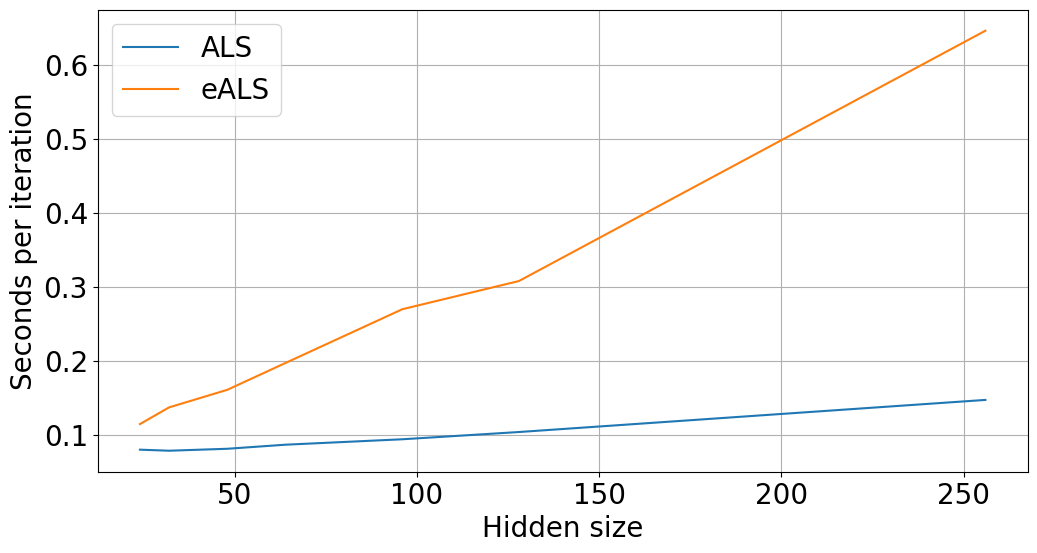

In [22]:
plt.rcParams.update({'font.size': 20})
times = np.array(times)
plt.figure(figsize=(12, 6))
plt.plot(hidden_sizes, times[:, 0], label='ALS')
plt.plot(hidden_sizes, times[:, 1], label='eALS')
plt.xlabel('Hidden size')
plt.ylabel('Seconds per iteration')
plt.legend()
plt.grid();

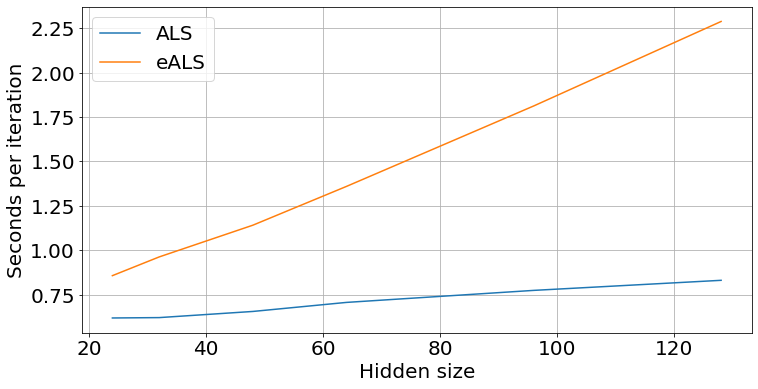

In [35]:
plt.rcParams.update({'font.size': 20})
times = np.array(times)
plt.figure(figsize=(12, 6))
plt.plot(hidden_sizes, times[:, 0], label='ALS')
plt.plot(hidden_sizes, times[:, 1], label='eALS')
plt.xlabel('Hidden size')
plt.ylabel('Seconds per iteration')
plt.legend()
plt.grid();

In [24]:
model = eALS(factors, iterations=iterations, device=device)
logs_eALS = model.fit(user_item)

  0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
model_als = ALS(factors, iterations=iterations, device=device)
logs_ALS = model_als.fit(user_item)

  0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
hit_ratio = []
for user_id in tqdm(np.unique(rows)):
    predictions = model_als.predict(user_id, 1000)
    item = test_items_indices[user_id]
    hit_ratio.append(item in predictions)
    
hit_ratio = np.array(hit_ratio)
hit_ratio.mean()

  0%|          | 0/12491 [00:00<?, ?it/s]

0.6025938675846609

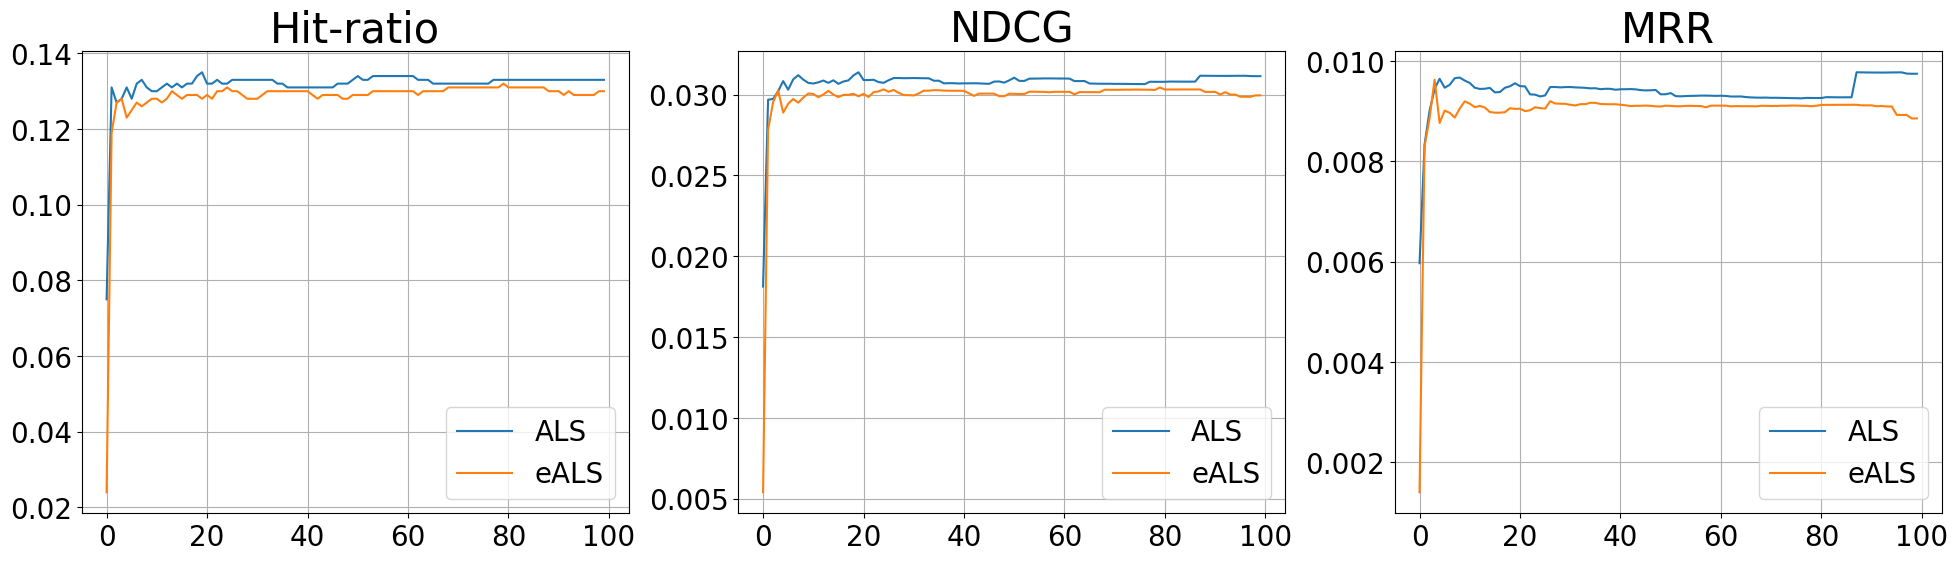

In [26]:
plt.rcParams.update({'font.size': 20})
logs = [logs_ALS, logs_eALS]
labels = ['ALS', 'eALS']
plot_visualization(logs, labels)

### Our implementation VS implicit

In [18]:
times_als = []
for hidden_size in hidden_sizes + [270]:
    model_als = ALS(hidden_size, iterations=iterations, device=device)
    start = time.time()
    model_als.fit(user_item)
    end = time.time()
    times_als.append(end - start)
    
times_als = np.array(times_als)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
hit_ratio = []
for user_id in tqdm(np.unique(rows)):
    predictions = model_als.predict(user_id, 1000)
    item = test_items_indices[user_id]
    hit_ratio.append(item in predictions)
    
hit_ratio = np.array(hit_ratio)
hit_ratio.mean()

  0%|          | 0/12491 [00:00<?, ?it/s]

0.3516131614762629

In [15]:
times_als_implicit = []
for hidden_size in hidden_sizes + [270]:
    model = AlternatingLeastSquares(factors=hidden_size, regularization=0.1, iterations=iterations, use_gpu=True)
    start = time.time()
    model.fit(user_item_scipy)
    end = time.time()
    times_als_implicit.append(end - start)
    
times_als_implicit = np.array(times_als_implicit)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

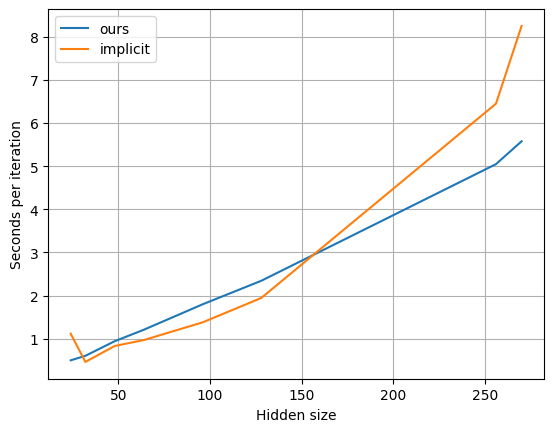

In [26]:
plt.plot(hidden_sizes + [270], times_als, label='ours')
plt.plot(hidden_sizes + [270], times_als_implicit, label='implicit')
plt.xlabel('Hidden size')
plt.ylabel('Seconds per iteration')
plt.legend()
plt.grid()
plt.show()

In [21]:
hit_ratio = []
for user_id in tqdm(np.unique(rows)):
    predictions = model.recommend(user_id, user_item_scipy[user_id], 1000)[0]
    item = test_items_indices[user_id]
    hit_ratio.append(item in predictions)
    
hit_ratio = np.array(hit_ratio)
hit_ratio.mean()

  0%|          | 0/12491 [00:00<?, ?it/s]

0.0